In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import os
from fk import params
from fk import model
from fk import convert
from fk import stimulus
import matplotlib.pyplot as plt
import jax
import jax.numpy as np


ModuleNotFoundError: No module named 'model'

# Experiments 
---

Parameters that works are:
- field_size = (12, 12)
- d = 0.001
- dx = 0.03
- dt = 0.01
- Convert field to shape
- Do not scale parameters and stimuli


## 1. Non chaotic
### 1.1 Stability
Testing the stability of a non chaotic simulations with two rectangular stimuli, delayed by 15000 time steps.

#### Settings
```python
field_size = (12, 12)  # cm
d = 0.001  # (cm^2/ms)
cell_parameters = params.params1a()
dx = 0.01  # (cm/units) - Fenton 1998 recommends ~200, 300 micron/gridunit (~0.02, 0.03), smaller dx means finer grid
dt = 0.01  # (ms) - Fenton 1998 recommends few hundreds of ms (~0.01, 0.04)
shape = convert.field_to_shape(field_size, dx)
protocol1 = stimulus.protocol(start=0, duration=2, period=0)
s1 = stimulus.rectangular(shape, jax.ops.index[-20:, :], 1., protocol1)
protocol2 = stimulus.protocol(start=15000, duration=2, period=0)
s2 = stimulus.rectangular(shape, jax.ops.index[:, -20:], 1., protocol2)
```
#### Results

| dx    | Stable | Quality                    |
|-------|--------|----------------------------|
| 0.08  | NO     | /                          |
| 0.05  | NO     | /                          |
| 0.04  | YES    | UNUSABLE                   |
| 0.03  | YES    | ACCEPTABLE                 |
| 0.025 | YES    | ACCEPTABLE                 |
| 0.02  | YES    | ACCEPTABLE AND SMOOTH      |
| 0.015 | YES    | ACCEPTABLE AND VERY SMOOTH |
| 0.01  | YES    | ACCEPTABLE AND VERY SMOOTH |

### 1.2 Convergence

```
# simulation inputs (real values)
field_size = (12, 12)  # cm
d = 0.001  # (cm^2/ms)
cell_parameters = params.params1a()

# infinitesimals
dx = 0.01  # (cm/units) - Fenton 1998 recommends ~200, 300 micron/gridunit (~0.02, 0.03), smaller dx means finer grid
dt = 0.01  # (ms) - Fenton 1998 recommends few hundreds of ms (~0.01, 0.04)

stripe_size = int(shape[0] / 10)

protocol1 = stimulus.protocol(start=0, duration=2, period=0)
s1 = stimulus.rectangular(shape, jax.ops.index[-stripe_size:, :], 1., protocol1)

protocol2 = stimulus.protocol(start=15000, duration=2, period=0)
s2 = stimulus.rectangular(shape, jax.ops.index[:, -stripe_size:], 1., protocol2)

protocol3 = stimulus.protocol(start=20000, duration=2, period=0)
s3 = stimulus.rectangular(shape, jax.ops.index[stripe_size*2:stripe_size*4, stripe_size*2:stripe_size*4], 1., protocol3)

protocol4 = stimulus.protocol(start=25000, duration=2, period=0)
s4 = stimulus.rectangular(shape, jax.ops.index[stripe_size*4:stripe_size*5, :], 1., protocol4)
```

In [3]:
# simulation inputs (real values)
field_size = (12, 12)  # cm
d = 0.001  # (cm^2/ms)
cell_parameters = params.params2()

In [4]:
# infinitesimals
dx = 0.01  # (cm/units) - Fenton 1998 recommends ~200, 300 micron/gridunit (~0.02, 0.03), smaller dx means finer grid
dt = 0.01  # (ms) - Fenton 1998 recommends few hundreds of ms (~0.01, 0.04)

In [16]:
def show_stimuli(*stimuli, **kwargs):
    fig, ax = plt.subplots(1, len(stimuli), figsize=(kwargs.pop("figsize", None) or (10, 3)))
    vmin = kwargs.pop("vmin", -1)
    vmax = kwargs.pop("vmax", 1)
    cmap = kwargs.pop("cmap", "RdBu")
    for i, stimulus in enumerate(stimuli):
        im = ax[i].imshow(stimulus["field"], vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)
        plt.colorbar(im, ax=ax[i])
        ax[i].set_title("Stimulus %d" % i)
    plt.show()
    return

(1200, 1200)
real tissue size: (12, 12)
{'tau_v_plus': 10, 'tau_v1_minus': 10, 'tau_v2_minus': 10, 'tau_w_plus': 1000000.0, 'tau_w_minus': 1000000.0, 'tau_d': 0.25, 'tau_0': 10, 'tau_r': 190, 'tau_si': 1000000.0, 'k': 100000, 'V_csi': 1000000.0, 'V_c': 0.13, 'V_v': 1000000.0, 'Cm': 1}


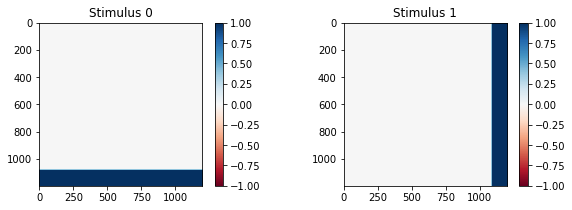

In [21]:
# to computational units
shape = convert.realsize_to_shape(field_size, dx)

stripe_size = int(shape[0] / 10)

protocol1 = stimulus.protocol(start=0, duration=2, period=0)
s1 = stimulus.rectangular(shape, (shape[0]-stripe_size/2,shape[0]/2), (stripe_size, shape[1]), 1., protocol1)

protocol2 = stimulus.protocol(start=25000, duration=2, period=0)
s2 = stimulus.rectangular(shape, (shape[1]/2, shape[0]-stripe_size/2), (shape[1], stripe_size), 1., protocol2)

# protocol3 = stimulus.protocol(start=20000, duration=2, period=0)
# s3 = stimulus.rectangular(shape, jax.ops.index[stripe_size*2:stripe_size*4, stripe_size*2:stripe_size*4], 1., protocol3)

# protocol4 = stimulus.protocol(start=30000, duration=2, period=0)
# s4 = stimulus.rectangular(shape, jax.ops.index[stripe_size*4:stripe_size*5, :], 1., protocol4)

stimuli = [s1, s2]

print(shape)
print("real tissue size:", field_size)
print(cell_parameters)
show_stimuli(*stimuli)

100


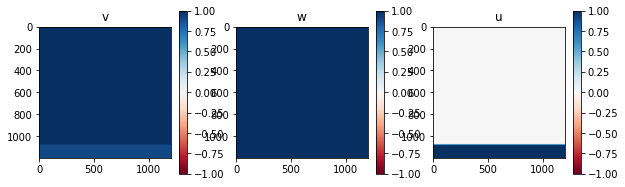

400


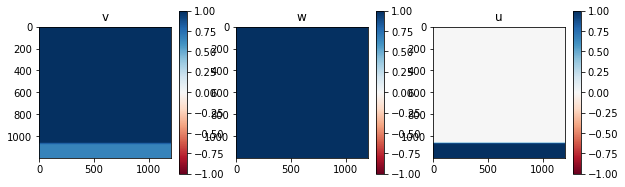

500


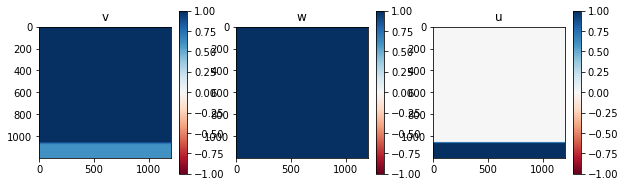

1000


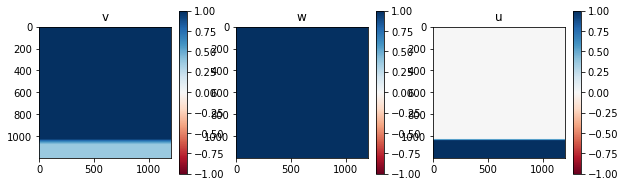

1500


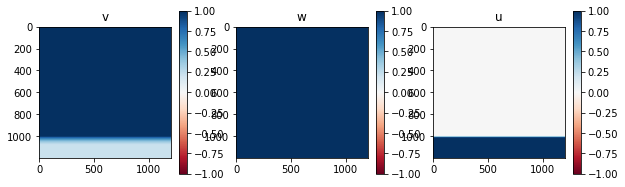

2000


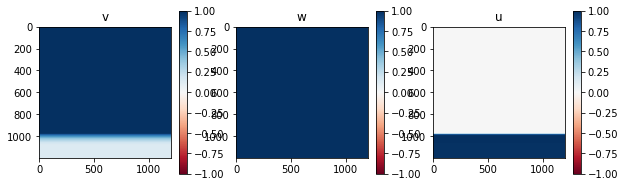

5000


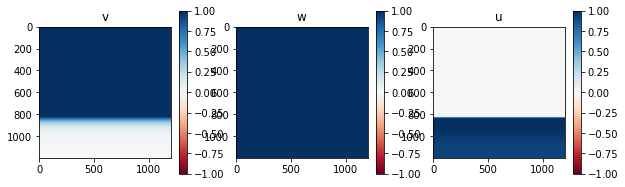

10000


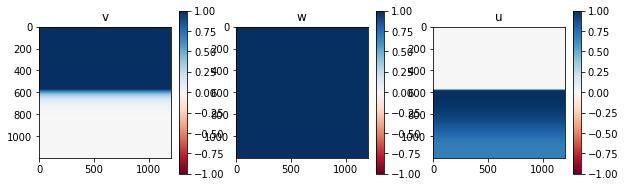

15000


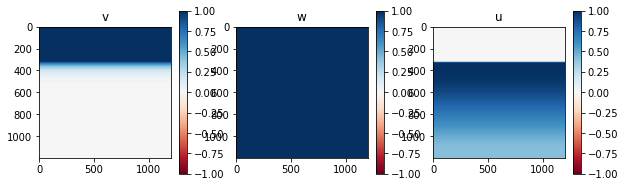

20000


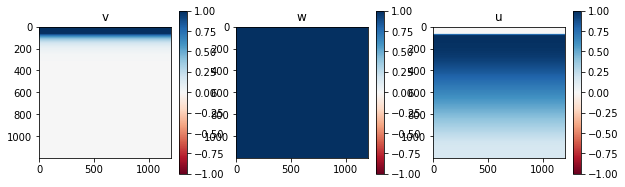

35000


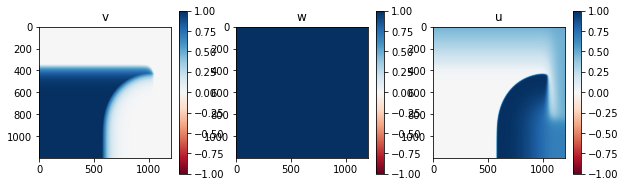

40000


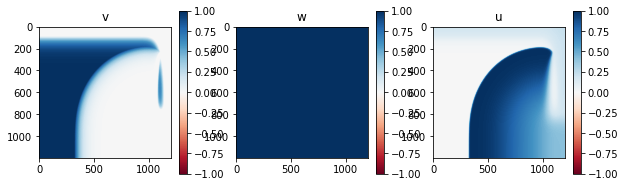

60000


KeyboardInterrupt: 

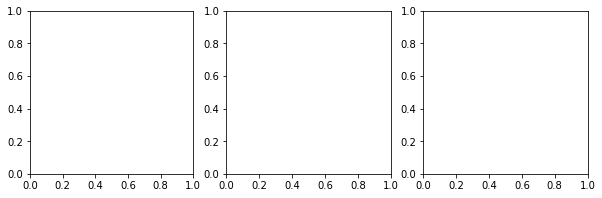

In [25]:
checkpoints = [10000, 15000, 20000, 35000, 40000, 60000, 100000, 110000, 120000, 130000, 140000, 150000]
state = model.init(shape)
for i in range(len(checkpoints) - 1):
    state = model._forward(state, checkpoints[i], checkpoints[i + 1], cell_parameters, np.ones(shape) * d, stimuli, dt, dx)  # dt = 10000
    print(checkpoints[i + 1])
    show(state)

In [ ]:
state = model.init(shape)
t = 0
model.show(state)

state = model.init(shape)
states = model._forward(state, 0, 50000, cell_parameters, np.ones(shape) * d, stimuli, dt, dx)
model.show(states)

In [ ]:
fig, ax = model.show(states)
path = os.path.join("results", "convergence", "chaotic", "dx_%.4f_param6.png" % dx)
fig.savefig(path)

In [34]:
np.mod(25000-26000,0)<2

DeviceArray(True, dtype=bool)